<a href="https://colab.research.google.com/github/atiaisaac/VICReg_TF/blob/main/VICReg_lincls_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

try:
  import wandb
except:
  !pip install --upgrade -q wandb
  import wandb

from wandb.keras import WandbCallback
from functools import partial
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00


In [2]:
tf.random.set_seed(42)

In [18]:
@dataclass
class C:
    DECAY = 1e-6
    EPOCHS = 100
    LR = 2e-2
    HEIGHT = 224
    BATCH_SIZE = 256
    AUTO = tf.data.experimental.AUTOTUNE
    SEED = 42
    BUFFER_SIZE = 1028
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.2,1.0)
    NUM_CLASSES = 5
    PATH = "/content/WEIGHTS_2023 03 08 (1).h5"

In [4]:
wandb.login()
wandb.init(
    project="vicreg_tpu",
    config={
        "learning_rate": C.LR,
        "batch_size": C.BATCH_SIZE,
        "optimizer" : "cosing decay schedule",
        "model": "Resnet50"
    },
    group = "ResNet",
    job_type = "evaluation"
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atiaisaac007. Use `wandb login --relogin` to force relogin


In [5]:
@tf.function
def _distorted_bounding_box_crop(
  image,bbox,min_object_covered=0.1,
  aspect_ratio_range=(0.75,1.33),
  area_range=(0.05,0.1),max_attempts=100
):
  shape = tf.shape(image)
  random_distorted_bbox = tf.image.sample_distorted_bounding_box(
      shape,
      bounding_boxes = bbox,
      min_object_covered = min_object_covered,
      aspect_ratio_range = aspect_ratio_range,
      area_range = area_range,
      max_attempts = max_attempts
  )
  offset,size,_ = random_distorted_bbox
  offset_y,offset_x,_ = tf.unstack(offset)
  target_y,target_x,_ = tf.unstack(size)
  image = tf.image.crop_to_bounding_box(
      image,offset_y,offset_x,target_y,target_x
  )
  return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
  bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
  # aspect_ratio = height / width
  image = _distorted_bounding_box_crop(
      image,bbox,
      area_range=area_range               
  )
  image = tf.image.resize(image,[height,width],method="bicubic")
  return image

In [6]:
train,val = tfds.load(
    "tf_flowers",
    as_supervised = True,
    split = ["train[:80%]","train[80%:]"],
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
@tf.function
def augmentation(image,label,transform="train"):
  if transform == "train":
    image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image,0,255)
    return image,label
  elif transform == "val":
    image = tf.image.central_crop(image,0.7)
    image = tf.image.resize(image,[C.HEIGHT,C.HEIGHT],method="bicubic")
    image = tf.clip_by_value(image,0,255)
    return image,label

In [8]:
train_ds = train.map(partial(augmentation,transform="train"))
train_ds = train_ds.shuffle(C.BUFFER_SIZE)
train_ds = train_ds.batch(C.BATCH_SIZE)
train_ds = train_ds.prefetch(C.AUTO)


val_ds = val.map(partial(augmentation,transform="val"))
val_ds = val_ds.batch(C.BATCH_SIZE)
val_ds = val_ds.prefetch(C.AUTO)

In [9]:
def visualize(sample):
  x,y = sample
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(x[n].numpy().astype("int"))
      plt.title(str(y[n].numpy()))
      plt.axis("off")
  plt.show()

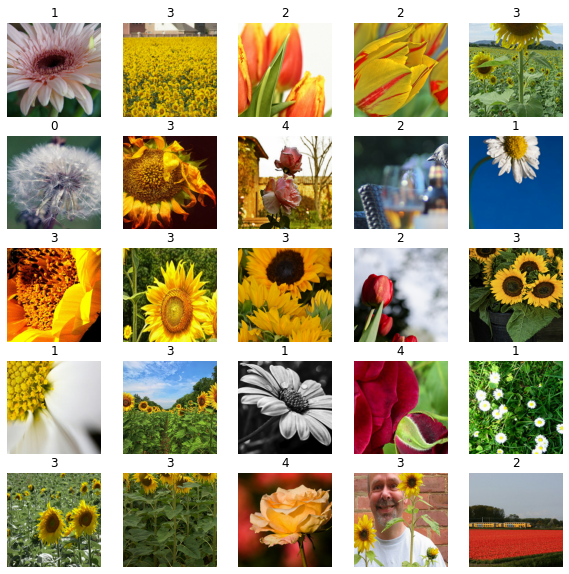

In [10]:
train_sample_one = next(iter(train_ds))
visualize(train_sample_one)

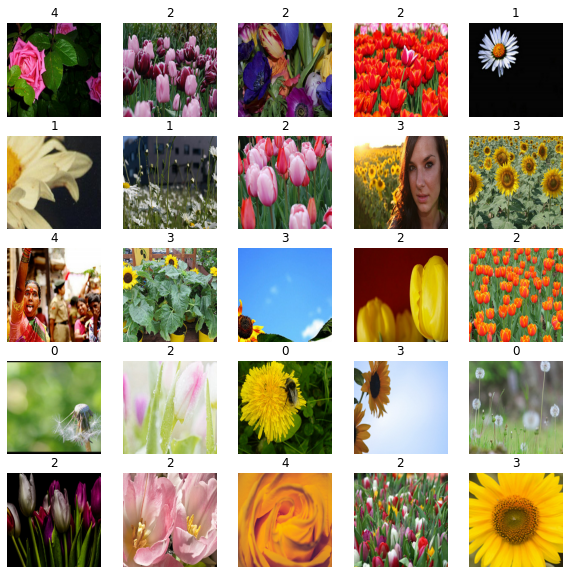

In [11]:
train_sample_two = next(iter(val_ds))
visualize(train_sample_two)

In [19]:
def encoder():
  i = tf.keras.Input(shape=[224,224,3])

  base = tf.keras.applications.resnet50.ResNet50(
        weights=None,
        include_top = False,
        input_shape = [*C.SHAPE,3]
    )
  base.trainable = False
  x = tf.keras.applications.resnet.preprocess_input(i)
  x = base(x,training=False)
  o = tf.keras.layers.GlobalAveragePooling2D()(x)
  return tf.keras.Model(inputs=i,outputs=o)

backbone = encoder()
backbone.load_weights(C.PATH)

In [20]:
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Dense(C.NUM_CLASSES,activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
total_steps = train_ds.cardinality().numpy() * C.EPOCHS
steps_per_epoch = train_ds.cardinality().numpy()
val_steps = val_ds.cardinality().numpy()

scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.LR,
    decay_steps = total_steps
)
optimizer = tfa.optimizers.SGDW(
    learning_rate = scheduler,
    weight_decay = C.DECAY,
    momentum=0.9
)

In [22]:
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [23]:
model.fit(
    train_ds,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_ds,
    validation_steps = val_steps,
    epochs = C.EPOCHS,
    callbacks = [WandbCallback()],
    verbose = 1
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.9105 - accuracy: 0.6877

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 70s 5s/step - loss: 0.9105 - accuracy: 0.6877 - val_loss: 0.4436 - val_accuracy: 0.8651
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8661

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 3s/step - loss: 0.4525 - accuracy: 0.8661 - val_loss: 0.3859 - val_accuracy: 0.8896
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.9067

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.5s


12/12 [==============================] - 42s 4s/step - loss: 0.3203 - accuracy: 0.9067 - val_loss: 0.3493 - val_accuracy: 0.9060
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9149

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.6s


12/12 [==============================] - 42s 4s/step - loss: 0.2719 - accuracy: 0.9149 - val_loss: 0.2902 - val_accuracy: 0.9196
Epoch 5/100
12/12 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9251

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 43s 4s/step - loss: 0.2140 - accuracy: 0.9251 - val_loss: 0.2793 - val_accuracy: 0.9183
Epoch 6/100
12/12 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9315

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.1972 - accuracy: 0.9315 - val_loss: 0.2677 - val_accuracy: 0.9264
Epoch 7/100
12/12 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9411

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.1750 - accuracy: 0.9411 - val_loss: 0.2512 - val_accuracy: 0.9251
Epoch 8/100
12/12 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9441

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 3s/step - loss: 0.1694 - accuracy: 0.9441 - val_loss: 0.2473 - val_accuracy: 0.9292
Epoch 9/100
12/12 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9452

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 47s 4s/step - loss: 0.1506 - accuracy: 0.9452 - val_loss: 0.2400 - val_accuracy: 0.9223
Epoch 10/100
12/12 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9493

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 3s/step - loss: 0.1415 - accuracy: 0.9493 - val_loss: 0.2339 - val_accuracy: 0.9292
Epoch 11/100
12/12 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9567

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.1297 - accuracy: 0.9567 - val_loss: 0.2286 - val_accuracy: 0.9305
Epoch 12/100
12/12 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9527

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.5s


12/12 [==============================] - 41s 4s/step - loss: 0.1319 - accuracy: 0.9527 - val_loss: 0.2277 - val_accuracy: 0.9292
Epoch 13/100
12/12 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9506

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.5s


12/12 [==============================] - 41s 4s/step - loss: 0.1279 - accuracy: 0.9506 - val_loss: 0.2231 - val_accuracy: 0.9292
Epoch 14/100
12/12 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9619

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 3s/step - loss: 0.1218 - accuracy: 0.9619 - val_loss: 0.2125 - val_accuracy: 0.9292
Epoch 15/100
12/12 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9683

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.1033 - accuracy: 0.9683 - val_loss: 0.2099 - val_accuracy: 0.9305
Epoch 16/100
12/12 [==============================] - 14s 1s/step - loss: 0.1128 - accuracy: 0.9598 - val_loss: 0.2166 - val_accuracy: 0.9278
Epoch 17/100
12/12 [==============================] - 14s 1s/step - loss: 0.1135 - accuracy: 0.9605 - val_loss: 0.2247 - val_accuracy: 0.9278
Epoch 18/100
12/12 [==============================] - 14s 1s/step - loss: 0.1201 - accuracy: 0.9591 - val_loss: 0.2453 - val_accuracy: 0.9237
Epoch 19/100
12/12 [==============================] - 13s 995ms/step - loss: 0.1182 - accuracy: 0.9588 - val_loss: 0.2217 - val_accuracy: 0.9278
Epoch 20/100
12/12 [==============================] - 13s 983ms/step - loss: 0.0958 - accuracy: 0.9724 - val_loss: 0.2148 - val_accuracy: 0.9278
Epoch 21/100
12/12 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.9639

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.5s


12/12 [==============================] - 43s 4s/step - loss: 0.1012 - accuracy: 0.9639 - val_loss: 0.2095 - val_accuracy: 0.9346
Epoch 22/100
12/12 [==============================] - 13s 995ms/step - loss: 0.0915 - accuracy: 0.9714 - val_loss: 0.2182 - val_accuracy: 0.9292
Epoch 23/100
12/12 [==============================] - 13s 993ms/step - loss: 0.1059 - accuracy: 0.9622 - val_loss: 0.2222 - val_accuracy: 0.9251
Epoch 24/100
12/12 [==============================] - 14s 1s/step - loss: 0.0945 - accuracy: 0.9687 - val_loss: 0.2341 - val_accuracy: 0.9237
Epoch 25/100
12/12 [==============================] - 14s 972ms/step - loss: 0.0802 - accuracy: 0.9745 - val_loss: 0.2099 - val_accuracy: 0.9332
Epoch 26/100
12/12 [==============================] - 13s 983ms/step - loss: 0.0869 - accuracy: 0.9721 - val_loss: 0.2136 - val_accuracy: 0.9319
Epoch 27/100
12/12 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9629

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.1063 - accuracy: 0.9629 - val_loss: 0.2078 - val_accuracy: 0.9305
Epoch 28/100
12/12 [==============================] - 13s 980ms/step - loss: 0.0991 - accuracy: 0.9642 - val_loss: 0.2199 - val_accuracy: 0.9251
Epoch 29/100
12/12 [==============================] - 14s 1s/step - loss: 0.0834 - accuracy: 0.9741 - val_loss: 0.2218 - val_accuracy: 0.9346
Epoch 30/100
12/12 [==============================] - 13s 1s/step - loss: 0.0937 - accuracy: 0.9673 - val_loss: 0.2112 - val_accuracy: 0.9346
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9697

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 41s 4s/step - loss: 0.0908 - accuracy: 0.9697 - val_loss: 0.2045 - val_accuracy: 0.9346
Epoch 32/100
12/12 [==============================] - 14s 962ms/step - loss: 0.0855 - accuracy: 0.9748 - val_loss: 0.2123 - val_accuracy: 0.9319
Epoch 33/100
12/12 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9676

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 43s 4s/step - loss: 0.0978 - accuracy: 0.9676 - val_loss: 0.2014 - val_accuracy: 0.9373
Epoch 34/100
12/12 [==============================] - 14s 983ms/step - loss: 0.0869 - accuracy: 0.9710 - val_loss: 0.2143 - val_accuracy: 0.9278
Epoch 35/100
12/12 [==============================] - 13s 1s/step - loss: 0.0811 - accuracy: 0.9738 - val_loss: 0.2022 - val_accuracy: 0.9373
Epoch 36/100
12/12 [==============================] - 16s 1s/step - loss: 0.0798 - accuracy: 0.9721 - val_loss: 0.2288 - val_accuracy: 0.9264
Epoch 37/100
12/12 [==============================] - 14s 986ms/step - loss: 0.0793 - accuracy: 0.9738 - val_loss: 0.2323 - val_accuracy: 0.9278
Epoch 38/100
12/12 [==============================] - 13s 995ms/step - loss: 0.0672 - accuracy: 0.9785 - val_loss: 0.2086 - val_accuracy: 0.9414
Epoch 39/100
12/12 [==============================] - 13s 985ms/step - loss: 0.0803 - accuracy: 0.9748 - val_loss: 0.2111 - val_accuracy: 0.9346
Epoch 4

wandb: Adding directory to artifact (/content/wandb/run-20230308_153925-894e1pvw/files/model-best)... Done. 0.4s


12/12 [==============================] - 42s 4s/step - loss: 0.0665 - accuracy: 0.9785 - val_loss: 0.1979 - val_accuracy: 0.9387
Epoch 56/100
12/12 [==============================] - 13s 983ms/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.2066 - val_accuracy: 0.9387
Epoch 57/100
12/12 [==============================] - 14s 984ms/step - loss: 0.0691 - accuracy: 0.9802 - val_loss: 0.2119 - val_accuracy: 0.9360
Epoch 58/100
12/12 [==============================] - 13s 999ms/step - loss: 0.0698 - accuracy: 0.9792 - val_loss: 0.2020 - val_accuracy: 0.9401
Epoch 59/100
12/12 [==============================] - 13s 1s/step - loss: 0.0609 - accuracy: 0.9833 - val_loss: 0.2091 - val_accuracy: 0.9346
Epoch 60/100
12/12 [==============================] - 13s 998ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.2053 - val_accuracy: 0.9387
Epoch 61/100
12/12 [==============================] - 13s 976ms/step - loss: 0.0660 - accuracy: 0.9792 - val_loss: 0.2058 - val_accuracy: 0.9387
Epoc

In [24]:
model.evaluate(val_ds)

3/3 [==============================] - 3s 691ms/step - loss: 0.2075 - accuracy: 0.9387


[0.207475483417511, 0.9386920928955078]